In [15]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [2]:
#load the dataset
data = pd.read_csv('/content/tweet_emotions (1).csv')

In [3]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [4]:
data.shape

(40000, 3)

In [5]:
data.dtypes

tweet_id      int64
sentiment    object
content      object
dtype: object

In [6]:
#Summary of the dataset
data.describe()

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


In [7]:
# Checking for null values
data.isna().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [8]:
#no null values present

In [9]:
data['content'][1]

'Layin n bed with a headache  ughhhh...waitin on your call...'

In [10]:
#sentiment count
data['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [11]:
# Checking for duplicate values
data.duplicated().sum()

0

In [12]:
# No duplicate values present

***Basic Preprocessing***

*   Removing tags
*   lowercasing
*   removing punctuations
*   removing stopwords
*   lemmatization

Removing tags:

In [16]:
def remove_tags(raw_text):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', str(raw_text))
    return cleaned_text

data['content'] = data['content'].apply(remove_tags)

In [17]:
data['content'][1]

'Layin n bed with a headache  ughhhhwaitin on your call'

Lowercasing:

In [18]:
data['content'] = data['content'].apply(lambda x:x.lower())

Removing Punctuations:

In [19]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


data['content'] = data['content'].apply(lambda text: remove_punctuation(text))

In [20]:
data['content'][1]

'layin n bed with a headache  ughhhhwaitin on your call'

Removing stopwords:

In [21]:
import nltk
from nltk.corpus import stopwords

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
# Load the stopwords list
sw_list = stopwords.words('english')

In [24]:
# Remove stopwords from the 'review' column
data['content'] = data['content'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x: " ".join(x))

# Print the updated DataFrame
print(data)

         tweet_id   sentiment  \
0      1956967341       empty   
1      1956967666     sadness   
2      1956967696     sadness   
3      1956967789  enthusiasm   
4      1956968416     neutral   
...           ...         ...   
39995  1753918954     neutral   
39996  1753919001        love   
39997  1753919005        love   
39998  1753919043   happiness   
39999  1753919049        love   

                                                 content  
0      tiffanylue know listenin bad habit earlier sta...  
1                 layin n bed headache ughhhhwaitin call  
2                          funeral ceremonygloomy friday  
3                                wants hang friends soon  
4      dannycastillo want trade someone houston ticke...  
...                                                  ...  
39995                                    johnlloydtaylor  
39996                             happy mothers day love  
39997  happy mothers day mommies woman man long youre...  
39998  niaril

In [25]:
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants hang friends soon
4,1956968416,neutral,dannycastillo want trade someone houston ticke...


Lemmatization:

In [26]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [27]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data["content"] = data["content"].apply(lambda text: lemmatize_words(text))
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,layin n bed headache ughhhhwaitin call
2,1956967696,sadness,funeral ceremonygloomy friday
3,1956967789,enthusiasm,want hang friend soon
4,1956968416,neutral,dannycastillo want trade someone houston ticke...


***Feature Extraction Techniques:***



* BOW
* TF-IDF
* Word2Vec




In [28]:
x = data.iloc[:,2:3]
x.head()

,content
0,tiffanylue know listenin bad habit earlier sta...
1,layin n bed headache ughhhhwaitin call
2,funeral ceremonygloomy friday
3,want hang friend soon
4,dannycastillo want trade someone houston ticke...


In [29]:
y= data['sentiment']
y.head()

0         empty
1       sadness
2       sadness
3    enthusiasm
4       neutral
Name: sentiment, dtype: object

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=134)

In [31]:
x_train

,content
7855,reba wish could listen im canada website wont let
7658,tiwurayie geez one time row patience good thin...
20855,shebeegee jersey weather good charity drive
9353,blackheartbunny nope
26327,donmcallister need find keynote one least know...
...,...
7892,veeriwhoa oh silence verona wanting go jaja en...
1202,salamandroid properly dragged week
13687,im lazy bumboo jack always work friday
13862,jtsui wish could sat thats super busy day sund...


**BOW**

***Bags of words model*** : It is used to convert text documents to numerical vectors or bag of words.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
cv = CountVectorizer(stop_words = "english", min_df = 10, max_df=200, max_features = 2000)

In [34]:
#parse matrix to numpy array to_array
x_train_bow = cv.fit_transform(x_train['content']).toarray()
x_test_bow = cv.transform(x_test['content']).toarray()

In [35]:
print(cv.vocabulary_)

{'listen': 1034, 'canada': 276, 'website': 1898, 'row': 1449, 'weather': 1896, 'drive': 520, 'nope': 1199, 'food': 671, 'lost': 1056, 'lunch': 1065, 'book': 200, 'room': 1444, 'pack': 1242, 'spider': 1614, 'bite': 176, 'toe': 1764, 'hungry': 873, 'killing': 967, 'funny': 700, 'andy': 56, 'date': 443, 'birthday': 174, 'woot': 1945, 'facebook': 600, 'end': 553, 'exam': 583, 'cross': 416, 'finger': 646, 'oooh': 1227, 'actually': 14, 'idea': 881, 'ugh': 1822, 'fuck': 694, 'shift': 1529, 'prom': 1352, 'dress': 516, 'use': 1849, 'ipod': 912, 'touch': 1777, 'fine': 645, 'load': 1041, 'mo': 1137, 'drink': 518, 'mmm': 1135, 'ago': 28, 'used': 1850, 'kid': 962, 'ton': 1768, 'teeth': 1724, 'beer': 157, 'leg': 1015, 'wasted': 1887, 'half': 784, 'met': 1109, 'cute': 424, 'conversation': 385, 'welcome': 1905, 'waiting': 1872, 'picked': 1286, 'coming': 365, 'forward': 681, 'dat': 442, 'iphone': 911, 'macbook': 1068, 'flat': 656, 'gotta': 742, 'hello': 824, 'true': 1796, 'write': 1958, 'seeing': 1500,

In [36]:
len(cv.vocabulary_)

2000

**TF-IDF**

***Term Frequency-Inverse Document Frequency model (TFIDF)*** : It is used to convert text documents to matrix of tfidf features.

In [37]:
tfidfvec = TfidfVectorizer(stop_words = "english", min_df = 10, max_df=200, max_features = 2000)

In [38]:
#parse matrix to numpy array to_array
x_train_tfidf= tfidfvec.fit_transform(x_train['content']).toarray()
x_test_tfidf = tfidfvec.transform(x_test['content']).toarray()


In [39]:
print(tfidfvec.vocabulary_)

{'listen': 1034, 'canada': 276, 'website': 1898, 'row': 1449, 'weather': 1896, 'drive': 520, 'nope': 1199, 'food': 671, 'lost': 1056, 'lunch': 1065, 'book': 200, 'room': 1444, 'pack': 1242, 'spider': 1614, 'bite': 176, 'toe': 1764, 'hungry': 873, 'killing': 967, 'funny': 700, 'andy': 56, 'date': 443, 'birthday': 174, 'woot': 1945, 'facebook': 600, 'end': 553, 'exam': 583, 'cross': 416, 'finger': 646, 'oooh': 1227, 'actually': 14, 'idea': 881, 'ugh': 1822, 'fuck': 694, 'shift': 1529, 'prom': 1352, 'dress': 516, 'use': 1849, 'ipod': 912, 'touch': 1777, 'fine': 645, 'load': 1041, 'mo': 1137, 'drink': 518, 'mmm': 1135, 'ago': 28, 'used': 1850, 'kid': 962, 'ton': 1768, 'teeth': 1724, 'beer': 157, 'leg': 1015, 'wasted': 1887, 'half': 784, 'met': 1109, 'cute': 424, 'conversation': 385, 'welcome': 1905, 'waiting': 1872, 'picked': 1286, 'coming': 365, 'forward': 681, 'dat': 442, 'iphone': 911, 'macbook': 1068, 'flat': 656, 'gotta': 742, 'hello': 824, 'true': 1796, 'write': 1958, 'seeing': 1500,

In [40]:
len(tfidfvec.vocabulary_)


2000

**Word2Vec**

In [41]:
import gensim
import nltk
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess



In [42]:
# Download the 'punkt' resource
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [43]:
tweets = []
for doc in data['content']: #We sentence tokenize our doc then do preprocessing
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        tweets.append(simple_preprocess(sent))

In [44]:
#Model building by default dimension is 100 in gensim
model = gensim.models.Word2Vec(
    window=10,
    min_count=2
)

In [45]:
#building vocabulary
model.build_vocab(tweets)

In [46]:
#training our model (trained word2vec model)
model.train(tweets, total_examples=model.corpus_count, epochs=model.epochs)

(1231526, 1515840)

In [47]:
len(model.wv.index_to_key)   #no.of words in our vocabulary

13378

In [48]:
#we created vector for our words, now we will create vector to represent our contents
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [49]:
document_vector(data['content'].values[0])     #converted contents to vector with 100 dimension

array([-0.14145651,  0.18611047,  0.13536069, -0.03267511, -0.24071681,
       -0.87720597,  0.21915528,  0.76676583, -0.23357293, -0.40700042,
       -0.12702802, -0.26162043,  0.10840367, -0.00383445,  0.17102113,
       -0.3418922 ,  0.02712939, -0.5269321 , -0.00885427, -0.5162739 ,
        0.30035532,  0.09772775,  0.08715065, -0.08758625, -0.286594  ,
        0.15122467, -0.2787127 , -0.29608187, -0.30492628,  0.2305985 ,
        0.20178303,  0.1871085 ,  0.27940407, -0.5202638 ,  0.01879884,
        0.44440627,  0.13530648, -0.2438735 , -0.07077756, -0.91936773,
        0.00445092, -0.48194525, -0.15369458, -0.15989378,  0.57447976,
       -0.26534793, -0.2684675 ,  0.11317737,  0.4479161 ,  0.073847  ,
        0.16224945, -0.07804663, -0.15128718, -0.2901903 ,  0.10353071,
        0.34591058,  0.08483   , -0.07244901, -0.08722448,  0.33009475,
        0.23021881,  0.04863196, -0.11134457, -0.06724435, -0.26200584,
        0.30318588,  0.00916045,  0.14422947, -0.54156023,  0.43

In [50]:
import numpy as np
from tqdm import tqdm



In [71]:

X = np.array(X)

***Model Building and Evaluation***

1. Logistic regression

In [51]:
## Using BOW

In [52]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()

In [53]:
lr.fit(x_train_bow,y_train)
y_pred = lr.predict(x_test_bow)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
accuracy_score(y_test,y_pred)

0.27475

In [55]:
## Using Tf-IDF

In [56]:
lr= LogisticRegression()
lr.fit(x_train_tfidf,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [57]:
y_pred = lr.predict(x_test_tfidf)
accuracy_score(y_test,y_pred)

0.282

2. GaussianNB

In [58]:
## Using BOW

In [59]:
#Gaussian Naive Bayes algorithm
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

gnb.fit(x_train_bow,y_train)

GaussianNB()

In [60]:
y_pred = gnb.predict(x_test_bow)

from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y_test,y_pred)

0.038125

In [61]:
## Using TF-IDF

In [62]:
gnb = GaussianNB()

gnb.fit(x_train_tfidf,y_train)

GaussianNB()

In [63]:
y_pred = gnb.predict(x_test_tfidf)

accuracy_score(y_test,y_pred)

0.0385

3. RandomForestClassifier

In [64]:
## Using BOW

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

rf.fit(x_train_bow,y_train)
y_pred = rf.predict(x_test_bow)
accuracy_score(y_test,y_pred)

0.248125

In [67]:
## Using TF-IDF

In [70]:
rf = RandomForestClassifier()

rf.fit(x_train_tfidf,y_train)
y_pred = rf.predict(x_test_tfidf)
accuracy_score(y_test,y_pred)

0.25625

Out of the above comparitively accuracy is high for **Logistic Regression Model with TF-IDF** feature extraction technique.
Hence,Best performing one in this case is Logistic Regression model with TF-IDF feature extraction technique

Now, we will try increasing no.of features

In [72]:
## With max features = 10000

In [74]:
cv = CountVectorizer(max_features=10000)

x_train_bow = cv.fit_transform(x_train['content']).toarray()
x_test_bow = cv.transform(x_test['content']).toarray()


lr= LogisticRegression()

lr.fit(x_train_bow,y_train)
y_pred = lr.predict(x_test_bow)
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.339375

In [76]:
tfidfvec = TfidfVectorizer(max_features=10000)

x_train_tfidf = tfidfvec.fit_transform(x_train['content']).toarray()
x_test_tfidf = tfidfvec.transform(x_test['content']).toarray()

lr= LogisticRegression()

lr.fit(x_train_tfidf,y_train)
y_pred = lr.predict(x_test_tfidf)
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.352875

In [77]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

In [78]:
print('The accuracy score is: ', accuracy_score(y_test,y_pred))

The accuracy score is:  0.352875


In [82]:
confusion_matrix(y_test,y_pred)

array([[  0,   0,   0,   0,   0,   2,   2,   0,   8,   1,   2,   1,  10],
       [  0,   1,   0,   0,   0,   1,   0,   1,  14,   0,   1,   0,  12],
       [  0,   0,   0,   0,   1,  13,   1,   2, 100,   1,  10,   1,  39],
       [  0,   0,   0,   0,   1,  28,   1,   8,  63,   0,   9,   1,  39],
       [  0,   0,   0,   0,   9,  82,   1,  20, 118,   0,  12,   1,  86],
       [  0,   0,   0,   0,  11, 380,   2,  87, 366,   5,  23,  11, 173],
       [  0,   0,   0,   0,   0,   7,  35,   4,  65,   0,  48,   2, 103],
       [  0,   0,   0,   0,   5, 166,   2, 302, 180,   2,  25,   1,  98],
       [  0,   0,   0,   0,   9, 149,   6,  50, 935,   4,  90,   2, 434],
       [  0,   0,   0,   0,   1,  43,   0,  18, 110,  17,  19,   1,  91],
       [  0,   0,   0,   0,   3,  58,  10,  27, 262,   0, 280,   2, 393],
       [  0,   0,   0,   0,   2,  70,   3,  27, 163,   1,  34,  11, 110],
       [  0,   0,   0,   0,   7,  83,  14,  34, 553,   6, 206,   3, 853]])

In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        26
     boredom       1.00      0.03      0.06        30
       empty       0.00      0.00      0.00       168
  enthusiasm       0.00      0.00      0.00       150
         fun       0.18      0.03      0.05       329
   happiness       0.35      0.36      0.36      1058
        hate       0.45      0.13      0.21       264
        love       0.52      0.39      0.44       781
     neutral       0.32      0.56      0.41      1679
      relief       0.46      0.06      0.10       300
     sadness       0.37      0.27      0.31      1035
    surprise       0.30      0.03      0.05       421
       worry       0.35      0.48      0.41      1759

    accuracy                           0.35      8000
   macro avg       0.33      0.18      0.18      8000
weighted avg       0.35      0.35      0.32      8000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

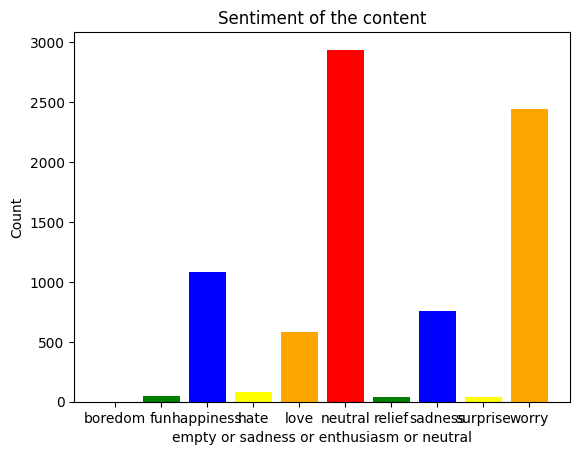

In [85]:
unique, counts = np.unique(y_pred, return_counts=True)
counts_dict = dict(zip(unique, counts))
# Define colors for each class
colors = ['red', 'green','blue','yellow','orange']

# Create a bar graph
plt.bar(counts_dict.keys(), counts_dict.values(), color=colors)
plt.xlabel('empty or sadness or enthusiasm or neutral')
plt.ylabel('Count')
plt.xticks(list(counts_dict.keys()))
plt.title('Sentiment of the content')
plt.show()

# **CONCLUSION**

**with max features as 10000, we got accuracy for logistic regression model as 0.35 while using TF-IDF feature extraction Technique**

*The model might not fully capture the sentiments expressed in the text due to variations in language, expressions, or sarcasm.*

*Different sentiment analysis models may have different levels of accuracy and may perform differently based on the specific dataset and text inputs.So the predictions may vary.*